## Example plot for LFPy: Hay et al. (2011) spike waveforms
* https://github.com/LFPy/LFPy/blob/master/examples/LFPy-example-04.ipynb

In [1]:
import numpy as np
import sys
from urllib.request import urlopen
import ssl
from warnings import warn
import zipfile
import os
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import LFPy
import neuron
%matplotlib inline

--No graphics will be displayed.


In [2]:
# Fetch Hay et al. 2011 model files
if not os.path.isfile('FromModelDB/L5bPCmodelsEH/morphologies/cell1.asc'):
    #get the model files:
    u = urlopen('https://modeldb.science/download/139653',
                context=ssl._create_unverified_context())
    localFile = open('FromModelDB/L5bPCmodelsEH.zip', 'wb')
    localFile.write(u.read())
    localFile.close()
    #unzip:
    myzip = zipfile.ZipFile('FromModelDB/L5bPCmodelsEH.zip', 'r')
    myzip.extractall('FromModelDB/.')
    myzip.close()

#compile mod files every time, because of incompatibility with Mainen96 files:
if "win32" in sys.platform:
    pth = "L5bPCmodelsEH/mod/"
    warn("no autompile of NMODL (.mod) files on Windows.\n" 
         + "Run mknrndll from NEURON bash in the folder L5bPCmodelsEH/mod and rerun example script")
    if not pth in neuron.nrn_dll_loaded:
        neuron.h.nrn_load_dll(pth+"nrnmech.dll")
    neuron.nrn_dll_loaded.append(pth)
else:
    os.system('''
              cd FromModelDB/L5bPCmodelsEH/mod/
              nrnivmodl
              ''')
    neuron.load_mechanisms('FromModelDB/L5bPCmodelsEH/mod/')

/home/storage1/hyunsu_DATA/GitHub_Active/LFPy_practice/Examples_from_Official_LFPy/FromModelDB/L5bPCmodelsEH/mod
Mod files: "./CaDynamics_E2.mod" "./Ca_HVA.mod" "./Ca_LVAst.mod" "./epsp.mod" "./Ih.mod" "./Im.mod" "./K_Pst.mod" "./K_Tst.mod" "./Nap_Et2.mod" "./NaTa_t.mod" "./NaTs2_t.mod" "./SK_E2.mod" "./SKv3_1.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.so
Successfully created x86_64/special


In [3]:
# define cell parameters used as input to cell-class
cellParameters = {
    'morphology'    : 'FromModelDB/L5bPCmodelsEH/morphologies/cell1.asc',
    'templatefile'  : ['FromModelDB/L5bPCmodelsEH/models/L5PCbiophys3.hoc',
                       'FromModelDB/L5bPCmodelsEH/models/L5PCtemplate.hoc'],
    'templatename'  : 'L5PCtemplate',
    'templateargs'  : 'FromModelDB/L5bPCmodelsEH/morphologies/cell1.asc',
    'passive' : False,
    'nsegs_method' : None,
    'dt' : 2**-6,
    'tstart' : -159,
    'tstop' : 10,
    'v_init' : -60,
    'celsius': 34,
    'pt3d' : True,
}

# Generate the grid in xz-plane over which we calculate local field potentials
X, Y, Z = np.mgrid[-4:5:1, 1:2, -4:5:1] * 20
# define parameters for extracellular recording electrode, using optional method
electrodeParameters = {
    'sigma' : 0.3,          # extracellular conductivity
    'x' : X.flatten(),      # x,y,z-coordinates of contacts
    'y' : Y.flatten(),
    'z' : Z.flatten(),
    'method' : 'root_as_point',  #sphere source soma segment
    'N' : np.array([[0, 1, 0]]*X.size), #surface normals
    'r' : 2.5,              # contact site radius
    'n' : 20,               # datapoints for averaging
}

In [4]:
# delete old sections from NEURON namespace
LFPy.cell.neuron.h("forall delete_section()")

# Initialize cell instance, using the LFPy.Cell class
cell = LFPy.TemplateCell(**cellParameters)
cell.set_rotation(x=4.729, y=-3.166)

# Override passive reversal potential, AP is generated
for sec in cell.allseclist:
    for seg in sec:
        seg.e_pas = -59.5

# create extracellular electrode object for LFPs on grid
electrode = LFPy.RecExtElectrode(cell=cell, **electrodeParameters)

# perform NEURON simulation
# Simulated results saved as attribute `data` in the RecExtElectrode instance
cell.simulate(probes=[electrode])

/home/storage1/hyunsu_DATA/GitHub_Active/LFPy_practice/Examples_from_Official_LFPy/example_suppl.py:287: SyntaxWarning: invalid escape sequence '\m'
  ax1.text(60, 102, '20 $\mu$m')


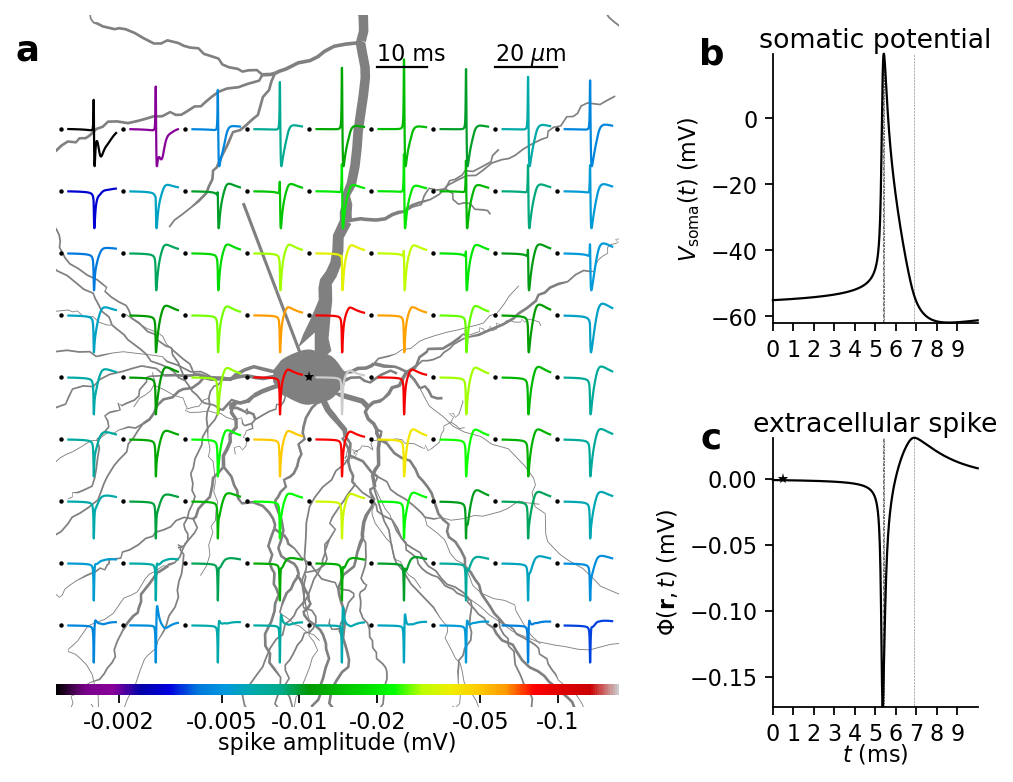

In [5]:
from example_suppl import plotstuff
fig = plotstuff(cell, electrode)
